
## Recomendador de películas basado en la semejanza de la sinopsis.
Introduciremos un título de la base de datos con casi 35 mil películas y obtendremos las 10 películas mas semejantes.
# Índice
0. Instalar librerías
1. Cargar el dataset
2. Análisis exploratorio de los datos
3. Preprocesamiento de los datos
4. Wordclouds
5. Word Embeddings
6. Recomendaciones

## 0. Instalar librerías

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import numpy as np
import matplotlib.pyplot as plt

## 1. Cargamos el dataset de Wikipedia Movie Plots

Se trata de un conjunto de datos que contiene sinopsis de casi 35 mil películas escrapeadas de la Wikipedia. El objetivo es que, dado el título de una película, te recomiende otras basadas en su sinopsis.
Link: https://www.kaggle.com/datasets/jp797498e/twitter-entity-sentiment-analysis/data


In [ ]:
# Definimos los nombres de las columnas
columnas_relevantes = ['Title', 'Director', 'Cast', 'Genre', 'Plot']
# Cargar el conjunto de datos
data = pd.read_csv("wiki_movie_plots_deduped.csv", encoding='utf-8', delimiter=',')

In [ ]:
# Obtener y mostrar el número de filas y columnas
nRow, nCol = data.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 34886 rows and 8 columns


In [ ]:
data.head(6)

,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot
0,1901,Kansas Saloon Smashers,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Kansas_Saloon_Sm...,"A bartender is working at a saloon, serving dr..."
1,1901,Love by the Light of the Moon,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Love_by_the_Ligh...,"The moon, painted with a smiling face hangs ov..."
2,1901,The Martyred Presidents,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/The_Martyred_Pre...,"The film, just over a minute long, is composed..."
3,1901,"Terrible Teddy, the Grizzly King",American,Unknown,NaN,unknown,"https://en.wikipedia.org/wiki/Terrible_Teddy,_...",Lasting just 61 seconds and consisting of two ...
4,1902,Jack and the Beanstalk,American,"George S. Fleming, Edwin S. Porter",NaN,unknown,https://en.wikipedia.org/wiki/Jack_and_the_Bea...,The earliest known adaptation of the classic f...
5,1903,Alice in Wonderland,American,Cecil Hepworth,May Clark,unknown,https://en.wikipedia.org/wiki/Alice_in_Wonderl...,"Alice follows a large white rabbit down a ""Rab..."


## 2. Análisis exploratorio de datos

En este apartado se realizará un análisis exploratorio de los datos. Se mostrará la distribución de las clases por categoría y veremos las nubes de palabras para cada clase.

In [ ]:
# Obtener información general sobre el dataframe
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34886 entries, 0 to 34885
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Release Year      34886 non-null  int64 
 1   Title             34886 non-null  object
 2   Origin/Ethnicity  34886 non-null  object
 3   Director          34886 non-null  object
 4   Cast              33464 non-null  object
 5   Genre             34886 non-null  object
 6   Wiki Page         34886 non-null  object
 7   Plot              34886 non-null  object
dtypes: int64(1), object(7)
memory usage: 2.1+ MB
None


In [ ]:
# Contar los valores nulos en cada columna
print(data.isnull().sum())

Release Year           0
Title                  0
Origin/Ethnicity       0
Director               0
Cast                1422
Genre                  0
Wiki Page              0
Plot                   0
dtype: int64


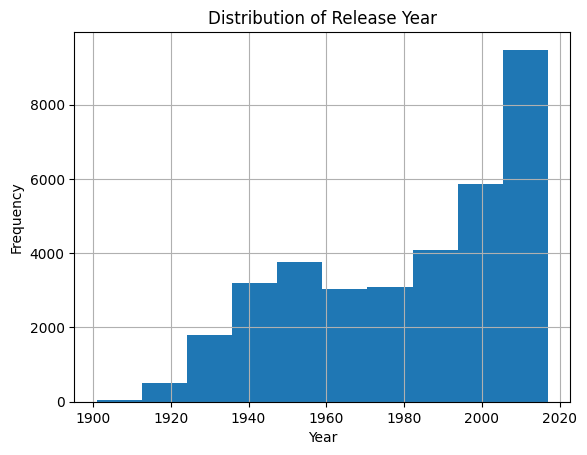

In [ ]:
# Mostramos la distribución de Release Year
data['Release Year'].hist()
plt.title("Distribution of Release Year")
plt.xlabel("Year")
plt.ylabel("Frequency")
plt.show()

## 3. Preprocesamiento de los datos

En esta sección, limpiaremos y preprocesaremos las sinopsis de las películas para eliminar ruido y normalizar el texto. Podemos considerar las siguientes variables/columnas en el dataset:

- Título (Title): Característica importante para representar la película.
- Director (Director): El director también puede ser relevante para identificar el estilo o género de la película.
- Reparto (Cast): El elenco puede influir en la temática o en el atractivo de la película para ciertos grupos de audiencia.
- Género (Genre): El género es una característica fundamental para determinar la similitud entre películas.
- Sinopsis (Plot): La sinopsis proporciona una descripción breve pero informativa de la trama de la película, lo que puede ser crucial para calcular la similitud entre películas.


Dado que el foco principal de nuestro problema es la similitud entre las sinopsis de las películas, nos centraremos principalmente en el preprocesamiento de la columna "Plot". Aquí están las técnicas de preprocesamiento que vamos a aplicar:

- Tokenización: Dividir el texto en palabras individuales o tokens.
- Eliminación de caracteres especiales y puntuación: Eliminar signos de puntuación y caracteres especiales que no son relevantes para el análisis.
- Conversión a minúsculas: Convertir todas las palabras a minúsculas para evitar inconsistencias debido a la diferencia entre mayúsculas y minúsculas.
- Eliminación de stopwords: Eliminar palabras comunes que no aportan mucho significado al texto, como "a", "the", "is", etc.
- Lematización o Stemming: Reducir las palabras a su forma base para consolidar palabras con el mismo significado.


Para representar las películas, podemos utilizar la técnica TF-IDF (Term Frequency-Inverse Document Frequency), que asigna pesos a cada palabra en función de su frecuencia en el documento y en el corpus. Esto nos dará una representación numérica de las sinopsis de las películas.

In [ ]:
# Mantener solo las columnas relevantes
data = data[columnas_relevantes]
# Obtener y mostrar el número de filas y columnas de los conjuntos de entrenamiento y prueba
nRow, nCol = data.shape
print(f'Set: {nRow} rows and {nCol} columns')

Set: 34886 rows and 5 columns


In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

def clean_text(text):
    # Tokenización
    tokens = word_tokenize(text)

    # Eliminación de caracteres especiales y puntuación
    tokens = [re.sub(r'[^a-zA-Z0-9]', '', word) for word in tokens]

    # Conversión a minúsculas
    tokens = [word.lower() for word in tokens]

    # Eliminación de stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    # Lematización
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # Eliminación de tokens vacíos
    tokens = [word for word in tokens if word != '']

    return ' '.join(tokens)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\yera_\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\yera_\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\yera_\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
# Aplicar preprocesamiento a la columna 'Plot'
data['Processed_Plot'] = data['Plot'].apply(clean_text)

In [ ]:
# Plot some stopwords
stopwords.words('english')[:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [ ]:
data.to_csv('data_clean.csv', index=False)

In [ ]:
# Leer dataset limpios para evitar volver a ejecutar el preprocesamiento
data = pd.read_csv('./data_clean.csv')

In [ ]:
# Print number of rows with empty values in any column
print(f"El dataset de tiene {data.isnull().any(axis=1).sum()} filas con valores nulos antes de la limpieza.")

# Eliminamos filas vacías
data = data.dropna()

El dataset de tiene 1422 filas con valores nulos antes de la limpieza.


In [ ]:
# Tras la limpieza
print(f"El dataset tiene {data.isnull().any(axis=1).sum()} filas con valores nulos después de la limpieza.")

El dataset tiene 0 filas con valores nulos después de la limpieza.


## 4. Wordclouds

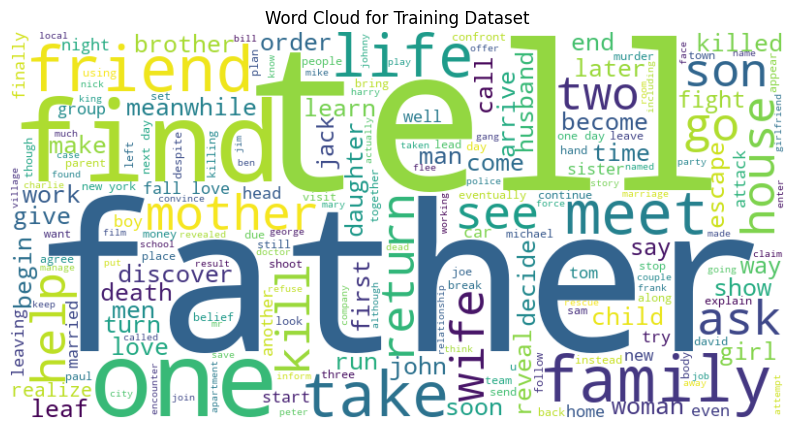

In [ ]:
from wordcloud import WordCloud
# Concatenar todas las sinopsis en una sola cadena de texto para el dataset de train
text = ' '.join(data['Processed_Plot'].dropna())

# Crear y mostrar la nube de palabras para el dataset de train
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Training Dataset')
plt.axis('off')
plt.show()


## 5. Word Embeddings
Para representar las películas, podemos utilizar la técnica TF-IDF (Term Frequency-Inverse Document Frequency), que asigna pesos a cada palabra en función de su frecuencia en el documento y en el corpus. Esto nos dará una representación numérica de las sinopsis de las películas.

### TF-IDF

In [ ]:
corpus = data['Processed_Plot'].tolist()
tfidf_vectorizer = TfidfVectorizer()
X = tfidf_vectorizer.fit_transform(corpus)
# Mostrar el vocabulario y la representación del corpus
print(f'El vocabulario es el siguiente: \n{tfidf_vectorizer.get_feature_names_out()}\n')
print(f'El corpus queda representado de la siguiente manera: \n{X.toarray()}\n')

El vocabulario es el siguiente: 
['00' '000' '0000' ... 'zyuland' 'zyuoh' 'zyuohgers']

El corpus queda representado de la siguiente manera: 
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]



In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

# Calcular la similitud coseno entre todas las películas
cosine_sim = cosine_similarity(X, X)
print(cosine_sim)

[[1.         0.00488478 0.02860308 ... 0.00368196 0.00769922 0.00408852]
 [0.00488478 1.         0.00334055 ... 0.         0.00136801 0.00164183]
 [0.02860308 0.00334055 1.         ... 0.00338211 0.         0.00560826]
 ...
 [0.00368196 0.         0.00338211 ... 1.         0.01034026 0.00886082]
 [0.00769922 0.00136801 0.         ... 0.01034026 1.         0.00278126]
 [0.00408852 0.00164183 0.00560826 ... 0.00886082 0.00278126 1.        ]]


## 6. Recomendaciones

In [ ]:
# Crear una Serie con los títulos de las películas
indices = pd.Series(data.index, index=data['Title']).drop_duplicates()

In [ ]:
# Crear la funcion de recomendación
def get_recommendations(title, cosine_sim=cosine_sim):
    # Obtener el índice de la película que coincide con el título
    idx = indices[title]

    # Obtener las puntuaciones de similitud de las películas con la película dada
    sim_scores = list(enumerate(cosine_sim[idx]))
    
    # Verificar si sim_scores está vacío
    if len(sim_scores) == 0:
        return "No se encontraron películas similares."

    # Ordenar las películas por la puntuación de similitud
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    
    # Obtener los índices de las 10 películas más similares
    sim_scores = sim_scores[1:11]
    movie_indices = [i[0] for i in sim_scores]
    
    # Devolver los títulos de las 10 películas más similares
    return data['Title'].iloc[movie_indices]

In [ ]:
print("Películas similares a 'The Black Viper':")
print(get_recommendations('The Black Viper'))